In [151]:
# check the cars that have a disabled parking permit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#import sys
#sys.path.append('/Users/dpelleg/miniconda/lib/python3.10/site-packages')

from statsmodels.stats.proportion import proportions_ztest

# do I need this? how to persist the change in path?


In [2]:
datadir = '../data/'

def count_repeated_chars(string, k):
    count = 0
    for i in range(len(string)-(k-1)):
        if string[i:i+k] == string[i]*k:
            count += 1
    return count

def is_palindrome(string):
    return string == string[::-1]

def has_numeric_sequence_3(string):
    for i in range(len(string)-2):
        if int(string[i])+1 == int(string[i+1]) and int(string[i+1])+1 == int(string[i+2]):
            return True
    return False

def has_numeric_sequence_3_rev(string):
    return has_numeric_sequence_3(string[::-1])

def count_distinct_chars(string):
    return len(set(string))

def distinct_chars_under(s, n):
    return count_distinct_chars(s) <= n

def distinct_chars_over(s, n):
    return count_distinct_chars(s) >= n

def count_repeated_sequences(string, seq_length):
    count = 0
    for i in range(len(string) - seq_length + 1):
        if string[i:i+seq_length] in string[i+seq_length:]:
            count += 1
    return count

scoremap = {
    lambda s: count_repeated_chars(s, 2): 1,
    lambda s: count_repeated_chars(s, 3): 1,
    lambda s: count_repeated_chars(s, 4): 1,
    is_palindrome: 5,
    has_numeric_sequence_3 : 2,
    has_numeric_sequence_3_rev : 2,
    lambda s: distinct_chars_under(s, 1): 10,
    lambda s: distinct_chars_under(s, 2): 5,
    lambda s: distinct_chars_under(s, 3): 2,
#    lambda s: distinct_chars_over(s, 5): 2,
#    lambda s: distinct_chars_over(s, 6): 5,
#    lambda s: distinct_chars_over(s, 7): 6,
#    lambda s: distinct_chars_over(s, 8): 8,
    lambda s: count_repeated_sequences(s, 2): 2,
    lambda s: count_repeated_sequences(s, 3): 3,
}

def score(s):
    ret = 0
    for idx, (f, mult) in enumerate(scoremap.items()):
        result = f(s)
        ret += mult*int(result)
    return ret

In [3]:
def read_file(fname, enc='iso8859-8'):
    fd = open(fname, encoding=enc, errors='replace')
    df = pd.read_csv(fd, sep='|')
    return df

def add_model(df):
    df['model'] = df.apply(lambda x: '_'.join([x[y] for y in ['tozeret_cd', 'degem_cd', 'shnat_yitzur', 'sug_degem']]), axis=1)

def get_model_name(ns):
    names = pd.DataFrame(data={'model':ns})
    ret = pd.merge(names, models, how='left', on='model')[['tozeret_nm', 'kinuy_mishari']]
    return ret

def ztest_proportions(df, population, test):
    xtab=pd.crosstab(df[population], df[test])
    se, pval = proportions_ztest(xtab[True].to_list(), xtab.sum(axis=1).to_list())
    return pval

In [4]:
# source : https://data.gov.il/dataset/private-and-commercial-vehicles/resource/053cea08-09bc-40ec-8f7a-156f0677aff3?inner_span=True

#df = pd.read_csv('data/rechev-small.csv', encoding='iso-8859-1', sep='|')
cars = read_file(datadir + 'rechev.csv')

for c in ['mispar_rechev', 'degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    cars[c] = cars[c].astype(str)

In [92]:
elec_cars = cars.query("sug_delek_nm == 'חשמל'").copy()

In [165]:
elec_cars.query('shnat_yitzur == "2022"')['kinuy_mishari'].value_counts()

GEOMETRY C         6795
MODEL 3            4088
ATTO 3             3708
IONIQ5             1742
U5                 1311
                   ... 
EQS580                1
AMG EQS53 4MATI       1
LOGISTAR 200          1
PROACE                1
RS E TRON GT          1
Name: kinuy_mishari, Length: 183, dtype: int64

In [101]:
capacities = pd.read_csv('../data/capacities.csv')
capacities

,make,model,capacity,max_power,avg_power_10_80,opt_range_low,opt_range_high
0,BYD,ATTO 3,58.00,86.0,71.8,2.0,63.0
1,MG,ZS EV,50.30,NaN,NaN,NaN,NaN
2,Audi,ETRON,64.00,126.0,106.6,4.0,72.0
3,GAC,GE3,54.75,NaN,NaN,NaN,NaN
4,Renault,ZOE,55.00,46.0,35.0,NaN,NaN
5,Jaguar,I-PACE,90.00,84.0,NaN,NaN,NaN
6,Tesla,MODEL 3,59.00,160.0,78.1,3.0,49.0
7,Always,U5,63.00,92.0,NaN,NaN,NaN
8,Peugeot,2008,50.00,100.0,NaN,NaN,NaN
9,Geely,GEOMTERY C,53.00,70.0,NaN,NaN,NaN


In [102]:
elec_cars = elec_cars.merge(right=capacities, left_on='kinuy_mishari', right_on='model', how='left')

In [104]:
elec_cars['time'] = pd.to_datetime(elec_cars['moed_aliya_lakvish'], format='%Y-%m').dt.strftime('%Y-%m')

In [171]:
elec_cars.query("time == '2022-08'")['kinuy_mishari'].value_counts()

GEOMETRY C        1173
U5                 205
IONIQ5             167
KONA               114
ET5                112
                  ... 
E-TRON GT            1
TAYCAN 4S            1
ENYAQ 60 EV          1
ETRON SBACK 55       1
COPPER SE            1
Name: kinuy_mishari, Length: 70, dtype: int64

In [169]:
elec_cars.query("kinuy_mishari == 'IONIQ5'")['time'].value_counts().sort_index()

2021-06      6
2021-07     18
2021-08     56
2021-09     16
2021-10     40
2021-11     15
2021-12      4
2022-01    318
2022-02    213
2022-03    100
2022-04    148
2022-05    282
2022-06    245
2022-07    105
2022-08    167
2022-09     45
2022-10     81
2022-11     37
2022-12      1
2023-01    556
2023-02     78
2023-03    549
2023-04    195
2023-05    286
2023-06    159
2023-07    125
2023-08     82
Name: time, dtype: int64

In [248]:
df = elec_cars.query("time > '2020-01'").groupby('time').agg({
    'capacity': ['mean', 'size'],
    'max_power': 'mean'
})

# Rename columns for clarity
df.columns = ['mean_capacity', 'size_capacity', 'mean_max_power']
df['total_capacity'] = df['mean_capacity'] * df['size_capacity']

In [249]:
df.tail()

,mean_capacity,size_capacity,mean_max_power,total_capacity
time,,,,
2023-04,62.338919,3349,117.013423,208773.039459
2023-05,62.669135,4215,133.518040,264150.402927
2023-06,60.592686,4762,145.893914,288542.371756
2023-07,61.741812,3937,119.732887,243077.514535
2023-08,59.905961,3740,167.805366,224048.293456


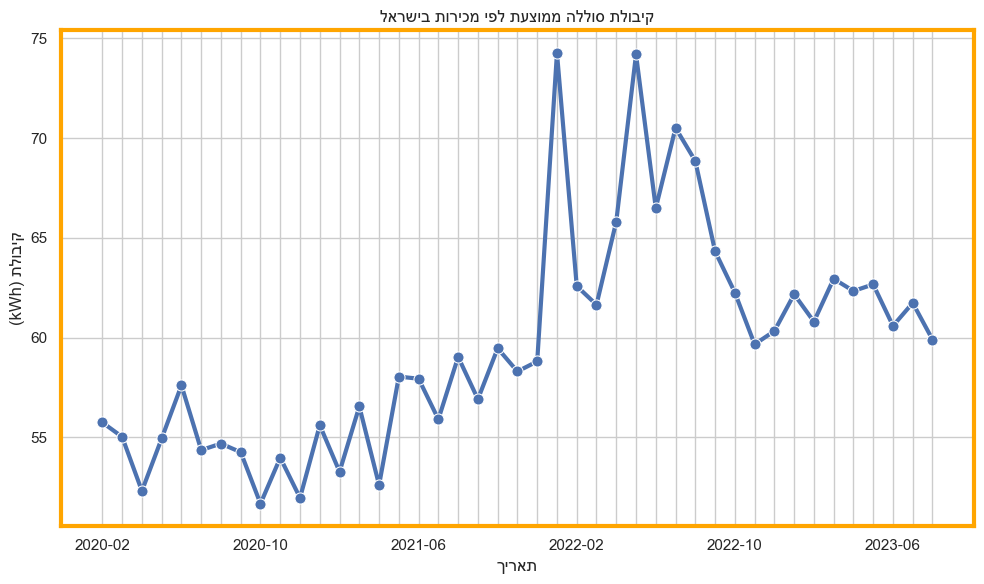

In [167]:
def sparsify_xticks(ax, spacing=10):
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % spacing == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

def rev(s):
    return s[::-1]

# Draw an orange frame around the chart
def nice_border():
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('orange')
        spine.set_linewidth(3)  # Set the border width

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the smoothed mean capacity over time with width 3
ax=sns.lineplot(x='time', y='mean_capacity', data=df, linewidth=3, marker='o', markersize=8)

plt.title(rev("קיבולת סוללה ממוצעת לפי מכירות בישראל"))
plt.xlabel(rev('תאריך'))
plt.ylabel('(kWh) ' + rev('קיבולת'))
sparsify_xticks(ax, 8)
nice_border()
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

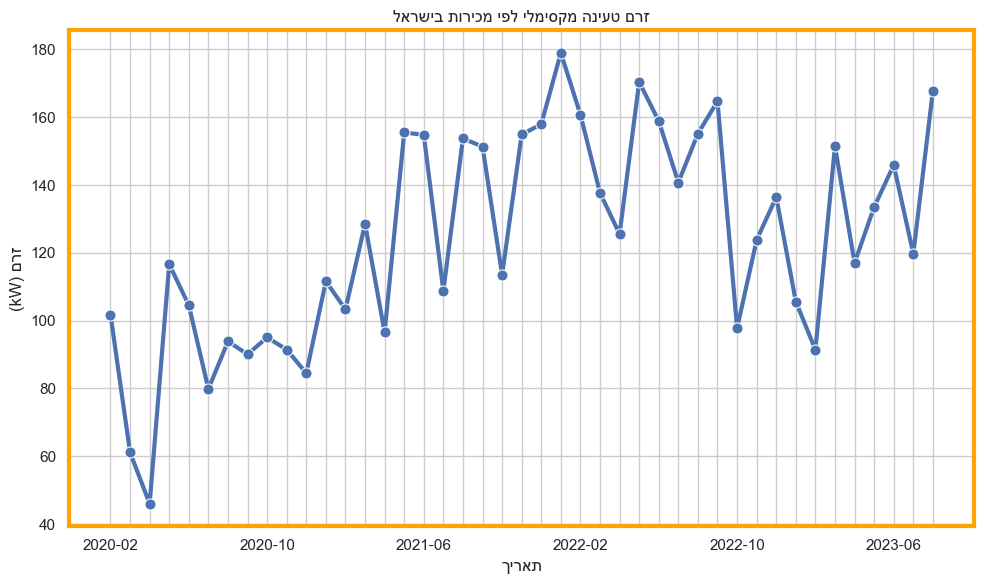

In [166]:
plt.figure(figsize=(10, 6))

ax=sns.lineplot(x='time', y='mean_max_power', data=df, linewidth=3, marker='o', markersize=8)

plt.title(rev("זרם טעינה מקסימלי לפי מכירות בישראל"))
plt.xlabel(rev('תאריך'))
plt.ylabel('(kW) ' +rev('זרם'))
sparsify_xticks(ax, 8)
nice_border()
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

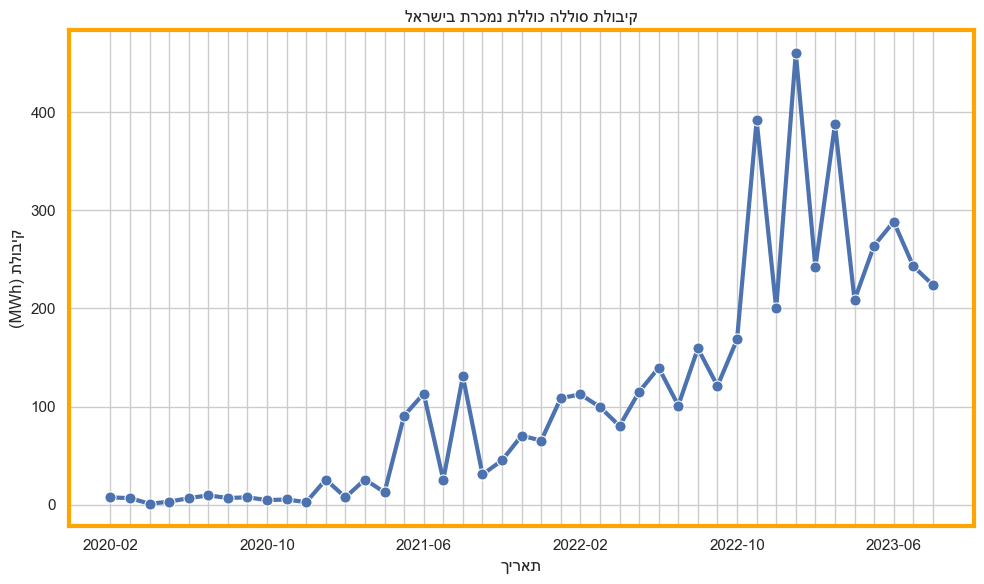

In [153]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the smoothed mean capacity over time with width 3
ax=sns.lineplot(x='time', y='total_capacity', data=df, linewidth=3, marker='o', markersize=8)

plt.title(rev("קיבולת סוללה כוללת נמכרת בישראל"))
plt.xlabel(rev('תאריך'))
plt.ylabel('(MWh) ' + rev('קיבולת'))
sparsify_xticks(ax, 8)
nice_border()

# Scale down Y-axis values and ticks by a factor of 1/1000
y_formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}')
plt.gca().yaxis.set_major_formatter(y_formatter)

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

In [247]:
# popular models
model='kinuy_mishari'
pop_models=elec_cars[model].value_counts().head(10).index.to_list()
#elec_cars['time'].value_counts().sort_index(ascending=False).head(10)

2023-08    3740
2023-07    3937
2023-06    4762
2023-05    4215
2023-04    3349
2023-03    6159
2023-02    3983
2023-01    7409
2022-12    3317
2022-11    6566
Name: time, dtype: int64

In [241]:
pop_models

['ATTO 3',
 'GEOMETRY C',
 'MODEL 3',
 'MODEL Y',
 'IONIQ5',
 'ZS EV',
 'U5',
 'KONA',
 'ENYAQ IV',
 'SERES 3']

In [242]:
# count model sales over time
df = elec_cars.query('kinuy_mishari in @pop_models')
count_df = df.groupby(['time', 'kinuy_mishari']).size().unstack()
#count_df = count_df.div(count_df.sum(axis=1), axis=0)

In [246]:
count_df.tail()

kinuy_mishari,ATTO 3,ENYAQ IV,GEOMETRY C,IONIQ5,KONA,MODEL 3,MODEL Y,SERES 3,U5,ZS EV
time,,,,,,,,,,
2023-04,1210.0,125.0,453.0,195.0,49.0,NaN,140.0,34.0,34.0,20.0
2023-05,1201.0,160.0,483.0,286.0,74.0,181.0,280.0,31.0,7.0,38.0
2023-06,1188.0,136.0,364.0,159.0,166.0,567.0,661.0,55.0,4.0,10.0
2023-07,1269.0,195.0,391.0,125.0,181.0,1.0,283.0,22.0,NaN,8.0
2023-08,776.0,112.0,445.0,82.0,61.0,386.0,903.0,21.0,NaN,23.0


<AxesSubplot: xlabel='time'>

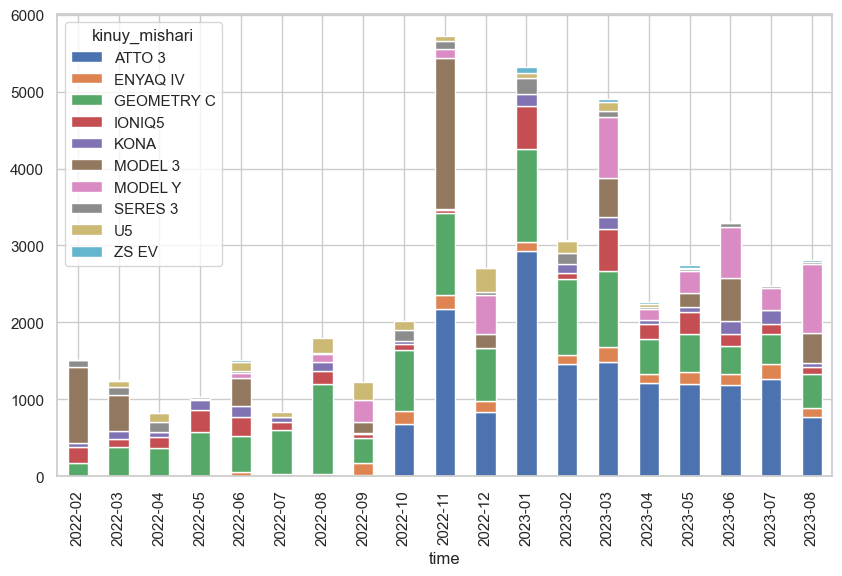

In [251]:
count_df.query('time > "2022-01"').plot(kind='bar', stacked=True, figsize=(10, 6))

In [212]:
elec_cars.query("time == '2023-08'")[model].value_counts().head(10)

MODEL Y          903
ATTO 3           776
GEOMETRY C       445
MODEL 3          386
ENYAQ IV         112
MG4              108
ORA FUNKY CAT     84
IONIQ5            82
TOYOTA BZ4X       73
IONIQ6            66
Name: kinuy_mishari, dtype: int64

In [29]:
count_df = cars.groupby(['time', 'sug_delek_nm']).size().unstack()
count_df = count_df.div(count_df.sum(axis=1), axis=0)

In [252]:
#count_df.query('time > "2021-01"').plot(kind='bar', stacked=True, figsize=(10, 6))